Импортируем модули

In [16]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set(font_scale=1.4)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import pandas as pd
from sklearn import decomposition
from keras.layers import Input, Dense, Conv2D, Activation, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import accuracy_score

Ссылка на датасет: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
Ссылка на notebook, на основе которого выполнялась работа: https://www.kaggle.com/code/vincee/intel-image-classification-cnn-keras

# Предобработка данных

Заполняем названия классов изображений

In [2]:
class_names = ['buildings', 'forest', 'glacier', 'mountain',
               'sea', 'street']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

Функция для загрузки изображений

In [3]:
def load_data():
  datasets = ['seg_train/seg_train', 
              'seg_test/seg_test']
  output = []

  for dataset in datasets:
    images = []
    labels = []

    print("Loading {}".format(dataset))

    for folder in os.listdir(dataset):
      label = class_names_label[folder]

      for file in tqdm(os.listdir(os.path.join(dataset, folder))):
        img_path = os.path.join(os.path.join(dataset, folder), file)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, IMAGE_SIZE)

        images.append(image)
        labels.append(label)

    images = np.array(images, dtype='float32')
    labels = np.array(labels, dtype='int32')

    output.append((images, labels))

  return output

Разбиваем изображения на тренировочное и тестовое множество

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading seg_train/seg_train


100%|██████████| 2382/2382 [00:13<00:00, 171.08it/s]


Loading seg_test/seg_test


100%|██████████| 501/501 [00:02<00:00, 176.51it/s]


Перемешиваем множества

In [5]:
train_images, train_labels = shuffle(train_images, train_labels,
                                     random_state=25)

Выводим информацию о множествах


In [6]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print("Количество примеров в обучающем множестве: {}".format(n_train))
print("Количество примеров в тестовом множестве: {}".format(n_test))
print("Размер каждого изображения: {}".format(IMAGE_SIZE))

Количество примеров в обучающем множестве: 14034
Количество примеров в тестовом множестве: 3000
Размер каждого изображения: (150, 150)


Количество изображений в каждой категории в тестовом и обучающем множестве

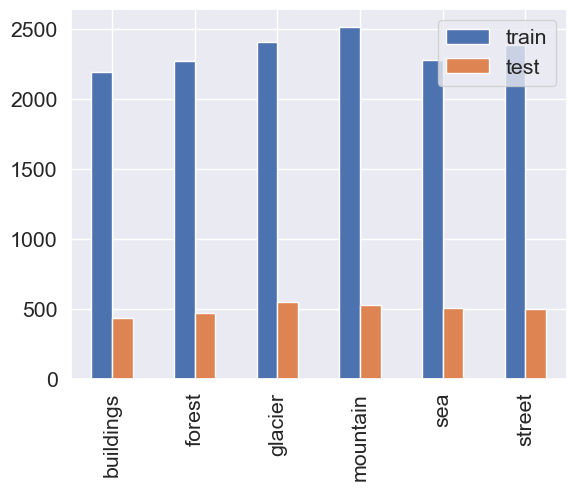

In [7]:
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
              'test': test_counts},
             index=class_names).plot.bar()
plt.show()

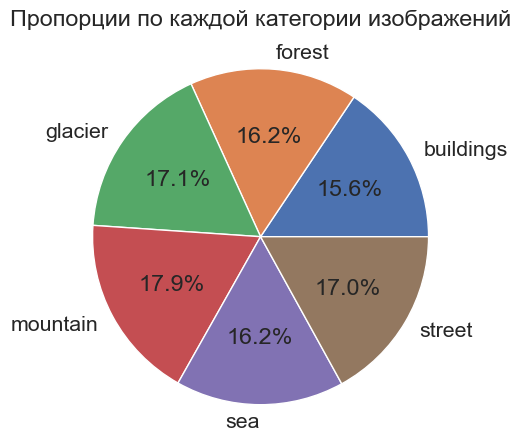

In [8]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0),
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Пропорции по каждой категории изображений', y=1.05)
plt.show()

Масштабируем данные

In [9]:
train_images = train_images / 255.0
test_images = test_images / 255.0

Функция для вывода нескольких изображений из датасета

In [10]:
def display_examples(class_names, images, labels):
  fig = plt.figure(figsize=(10,10))
  fig.suptitle("Примеры изображений из датасета", fontsize=16)
  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[labels[i]])
  plt.show()

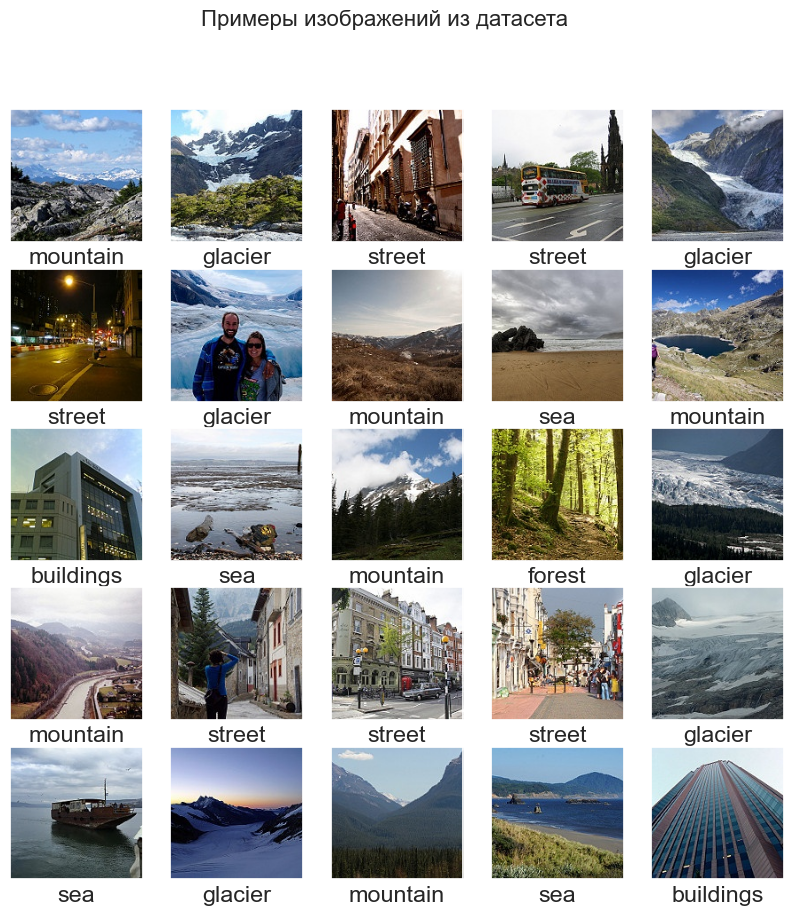

In [11]:
display_examples(class_names, train_images, train_labels)

# Первый вариант нейросети VGG16

Используем сверточную нейросеть VGG16 для классификации изображений

In [23]:
model = VGG16(weights='imagenet', include_top=False)

Прогнозируем вероятность отнесения к определенному классу

In [24]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

94/94 [==============================] - 150s 2s/step


Визуализируем данные с помощью представления в двумерном пространстве (через PCA)

In [25]:
n_train, x, y, z = train_features.shape
n_test, x, y, z = test_features.shape
numFeatures = x * y * z

In [26]:
pca = decomposition.PCA(n_components=2)

X = train_features.reshape((n_train, x*y*z))
pca.fit(X)

C = pca.transform(X)
C1 = C[:,0]
C2 = C[:,1]

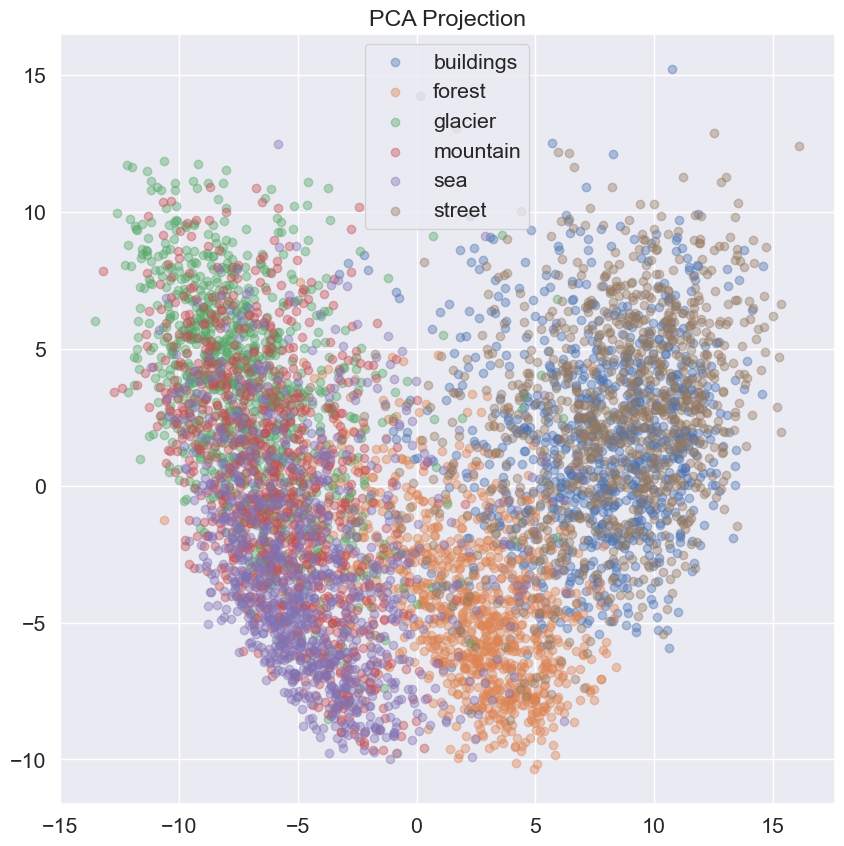

In [27]:
plt.subplots(figsize=(10,10))

for i, class_name in enumerate(class_names):
    plt.scatter(C1[train_labels == i][:1000], C2[train_labels == i][:1000], label=class_name, alpha=0.4)
plt.legend()
plt.title("PCA Projection")
plt.show()

Отчетливо выделяется класс - лес. Улицы и здания очень сильно пересекаются.Также происходит некоторое пересечение ледников, гор и морей.

Функция для визуализации лосс-функции и метрики

In [12]:
def plot_accuracy_loss(history):
    fig = plt.figure(figsize=(13, 8))
    
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

In [29]:
lr_rate = ReduceLROnPlateau(monitor='val_accuracy',
                            patience=1,
                            factor=0.25,
                            min_lr=0.000003)

Строим и обучаем нейросеть, которая будет определять класс после VGG16

In [35]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(x, y, z)),
    tf.keras.layers.Dense(80, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model2.fit(train_features, train_labels, batch_size=128, epochs=15, validation_split=0.2,
                     callbacks=[lr_rate])

Epoch 1/15
88/88 [==============================] - 2s 17ms/step - loss: 0.5578 - accuracy: 0.7966 - val_loss: 0.3665 - val_accuracy: 0.8657 - lr: 0.0010
Epoch 2/15
88/88 [==============================] - 1s 16ms/step - loss: 0.3157 - accuracy: 0.8862 - val_loss: 0.3273 - val_accuracy: 0.8864 - lr: 0.0010
Epoch 3/15
88/88 [==============================] - 1s 15ms/step - loss: 0.2374 - accuracy: 0.9171 - val_loss: 0.3332 - val_accuracy: 0.8810 - lr: 0.0010
Epoch 4/15
88/88 [==============================] - 1s 16ms/step - loss: 0.1746 - accuracy: 0.9426 - val_loss: 0.3090 - val_accuracy: 0.8860 - lr: 2.5000e-04
Epoch 5/15
88/88 [==============================] - 1s 15ms/step - loss: 0.1567 - accuracy: 0.9514 - val_loss: 0.3103 - val_accuracy: 0.8874 - lr: 6.2500e-05
Epoch 6/15
88/88 [==============================] - 1s 15ms/step - loss: 0.1536 - accuracy: 0.9530 - val_loss: 0.3103 - val_accuracy: 0.8867 - lr: 6.2500e-05
Epoch 7/15
88/88 [==============================] - 1s 15ms/step

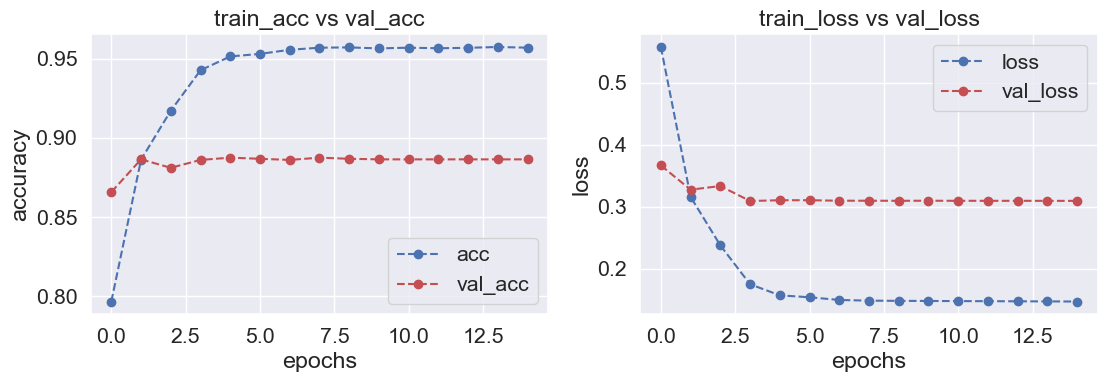

In [36]:
plot_accuracy_loss(history)

In [37]:
test_loss = model2.evaluate(test_features, test_labels)

94/94 [==============================] - 0s 3ms/step - loss: 0.3130 - accuracy: 0.8867


accuracy на тестовом множестве < 0.9

# Второй вариант нейросети VGG16

В качестве основы будем использовать VGG16

Убираем последние пять слоев нейросети

In [11]:
model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=model.inputs, outputs=model.layers[-5].output)

In [12]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

94/94 [==============================] - 140s 1s/step


Дополняем полученную нейросеть, последние четыре слоя VGG16 представляют собой MLP, поэтому изменим эти слои

In [13]:
model2 = VGG16(weights='imagenet', include_top=False)

input_shape = model2.layers[-4].get_input_shape_at(0)
layer_input = Input(shape=(9, 9, 512))

x = layer_input
for layer in model2.layers[-4::1]:
    x = layer(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(95, activation='relu')(x)
#x = Dense(20, activation='relu')(x)
x = Dense(6, activation='softmax')(x)

new_model = Model(layer_input, x)

In [14]:
new_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Структура полученной модели

In [15]:
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 9, 9, 512)]       0         
                                                                 
 block5_conv1 (Conv2D)       multiple                  2359808   
                                                                 
 block5_conv2 (Conv2D)       multiple                  2359808   
                                                                 
 block5_conv3 (Conv2D)       multiple                  2359808   
                                                                 
 block5_pool (MaxPooling2D)  multiple                  0         
                                                                 
 conv2d (Conv2D)             (None, 2, 2, 64)          294976    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 64)         0   

In [16]:
lr_rate = ReduceLROnPlateau(monitor='val_accuracy',
                            patience=1,
                            factor=0.25,
                            min_lr=0.000003)

Обучение нейросети

In [17]:
history = new_model.fit(train_features, train_labels, batch_size=128, epochs=10, validation_split=0.2,
                        callbacks=[lr_rate])

Epoch 1/10
88/88 [==============================] - 220s 2s/step - loss: 0.7629 - accuracy: 0.6962 - val_loss: 0.4232 - val_accuracy: 0.8522 - lr: 0.0010
Epoch 2/10
88/88 [==============================] - 222s 3s/step - loss: 0.3588 - accuracy: 0.8741 - val_loss: 0.3048 - val_accuracy: 0.8949 - lr: 0.0010
Epoch 3/10
88/88 [==============================] - 223s 3s/step - loss: 0.2658 - accuracy: 0.9108 - val_loss: 0.2825 - val_accuracy: 0.9077 - lr: 0.0010
Epoch 4/10
88/88 [==============================] - 219s 2s/step - loss: 0.2221 - accuracy: 0.9233 - val_loss: 0.2774 - val_accuracy: 0.9049 - lr: 0.0010
Epoch 5/10
88/88 [==============================] - 220s 2s/step - loss: 0.1413 - accuracy: 0.9528 - val_loss: 0.2632 - val_accuracy: 0.9113 - lr: 2.5000e-04
Epoch 6/10
88/88 [==============================] - 223s 3s/step - loss: 0.1156 - accuracy: 0.9603 - val_loss: 0.2714 - val_accuracy: 0.9141 - lr: 2.5000e-04
Epoch 7/10
88/88 [==============================] - 228s 3s/step - l

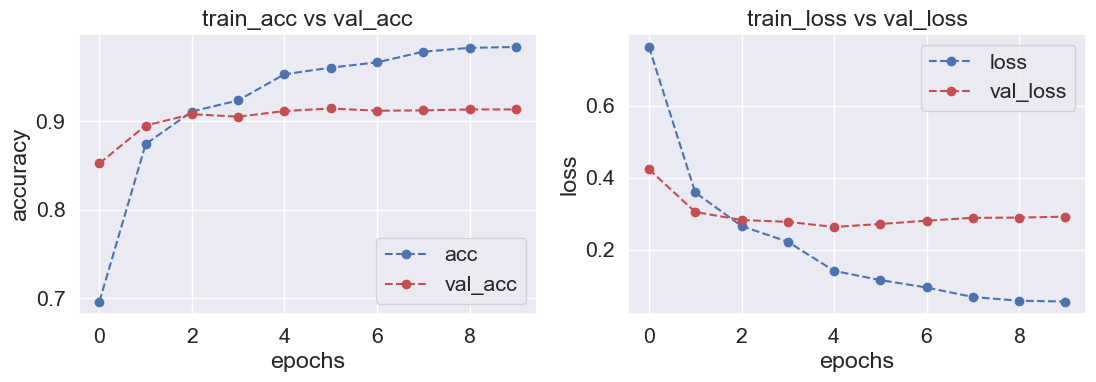

In [20]:
plot_accuracy_loss(history)

Итоговое значение accuracy

In [21]:
from sklearn.metrics import accuracy_score

predictions = new_model.predict(test_features)
pred_labels = np.argmax(predictions, axis=1)
print("Accuracy: {}".format(accuracy_score(test_labels, pred_labels)))

94/94 [==============================] - 12s 124ms/step
Accuracy: 0.9103333333333333


Accuracy > 0.9

# Нейросеть Inceptionv3

In [38]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

Создаем модель InceptionV3 без полносвязного слоя

In [39]:
model_inceptionV3 = InceptionV3(weights='imagenet', include_top=False)

Извлекаем признаки

In [40]:
train_features = model_inceptionV3.predict(train_images)
test_features = model_inceptionV3.predict(test_images)

94/94 [==============================] - 35s 371ms/step


In [41]:
_, x, y, z = train_features.shape

Строим небольшую полносвязную нейросеть, которая будет делать прогноз по извлеченным признакам

In [42]:
lr_rate = ReduceLROnPlateau(monitor='val_accuracy',
                            patience=1,
                            factor=0.25,
                            min_lr=0.000003)

In [43]:
model2_inceptionV3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(x, y, z)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model2_inceptionV3.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

history = model2_inceptionV3.fit(train_features, train_labels, batch_size=256,
                                 epochs=10, validation_split=0.2, callbacks=[lr_rate])

Epoch 1/10
44/44 [==============================] - 10s 221ms/step - loss: 2.9666 - accuracy: 0.7592 - val_loss: 0.3682 - val_accuracy: 0.8874 - lr: 0.0010
Epoch 2/10
44/44 [==============================] - 9s 208ms/step - loss: 0.3357 - accuracy: 0.8928 - val_loss: 0.3349 - val_accuracy: 0.8906 - lr: 0.0010
Epoch 3/10
44/44 [==============================] - 9s 209ms/step - loss: 0.2570 - accuracy: 0.9080 - val_loss: 0.3625 - val_accuracy: 0.8835 - lr: 0.0010
Epoch 4/10
44/44 [==============================] - 9s 209ms/step - loss: 0.2009 - accuracy: 0.9270 - val_loss: 0.2925 - val_accuracy: 0.9067 - lr: 2.5000e-04
Epoch 5/10
44/44 [==============================] - 9s 209ms/step - loss: 0.1725 - accuracy: 0.9374 - val_loss: 0.2941 - val_accuracy: 0.9070 - lr: 2.5000e-04
Epoch 6/10
44/44 [==============================] - 9s 209ms/step - loss: 0.1599 - accuracy: 0.9417 - val_loss: 0.2950 - val_accuracy: 0.9042 - lr: 2.5000e-04
Epoch 7/10
44/44 [==============================] - 9s 20

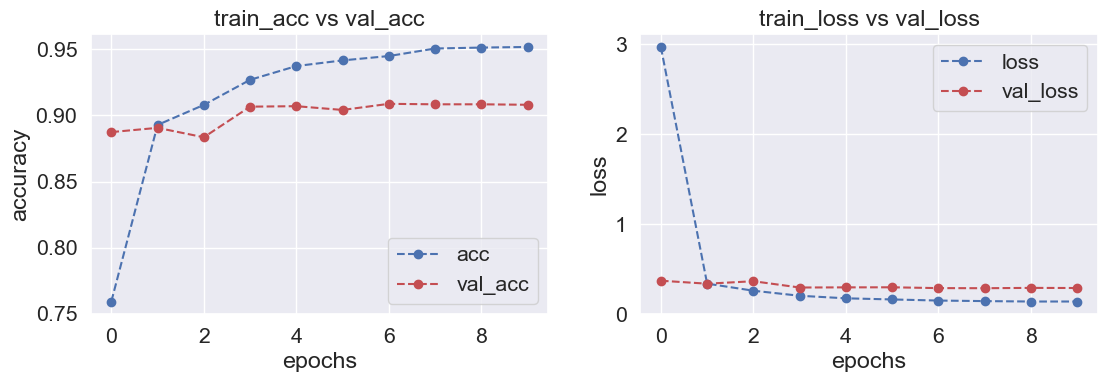

In [44]:
plot_accuracy_loss(history)

Итоговое значение Accuracy

In [46]:
from sklearn.metrics import accuracy_score

predictions = model2_inceptionV3.predict(test_features)
pred_labels = np.argmax(predictions, axis=1)
print("Accuracy: {}".format(accuracy_score(test_labels, pred_labels)))

94/94 [==============================] - 1s 9ms/step
Accuracy: 0.905


# Нейросеть Xception

In [47]:
from keras.applications import Xception

Создаем модель Xception

In [48]:
model_Xception = Xception(include_top=False, weights='imagenet')

83683744/83683744 [==============================] - 10s 0us/step


Извлекаем признаки

In [49]:
train_features = model_Xception.predict(train_images)
test_features = model_Xception.predict(test_images)

94/94 [==============================] - 85s 859ms/step


In [50]:
_, x, y, z = train_features.shape

Строим небольшую полносвязную нейросеть, которая будет делать прогноз по извлеченным признакам

In [51]:
lr_rate = ReduceLROnPlateau(monitor='val_accuracy',
                            patience=1,
                            factor=0.25,
                            min_lr=0.000003)

In [60]:
model2_Xception = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(x, y, z)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1024, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model2_Xception.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

history = model2_Xception.fit(train_features, train_labels, batch_size=256,
                                 epochs=10, validation_split=0.2, callbacks=[lr_rate])

Epoch 1/10
44/44 [==============================] - 52s 1s/step - loss: 3.1919 - accuracy: 0.8102 - val_loss: 0.4604 - val_accuracy: 0.8949 - lr: 0.0010
Epoch 2/10
44/44 [==============================] - 49s 1s/step - loss: 0.2852 - accuracy: 0.9092 - val_loss: 0.2545 - val_accuracy: 0.9124 - lr: 0.0010
Epoch 3/10
44/44 [==============================] - 49s 1s/step - loss: 0.1813 - accuracy: 0.9368 - val_loss: 0.2757 - val_accuracy: 0.8999 - lr: 0.0010
Epoch 4/10
44/44 [==============================] - 49s 1s/step - loss: 0.1373 - accuracy: 0.9516 - val_loss: 0.2392 - val_accuracy: 0.9170 - lr: 2.5000e-04
Epoch 5/10
44/44 [==============================] - 50s 1s/step - loss: 0.1247 - accuracy: 0.9595 - val_loss: 0.2393 - val_accuracy: 0.9152 - lr: 2.5000e-04
Epoch 6/10
44/44 [==============================] - 50s 1s/step - loss: 0.1094 - accuracy: 0.9658 - val_loss: 0.2414 - val_accuracy: 0.9152 - lr: 6.2500e-05
Epoch 7/10
44/44 [==============================] - 49s 1s/step - loss

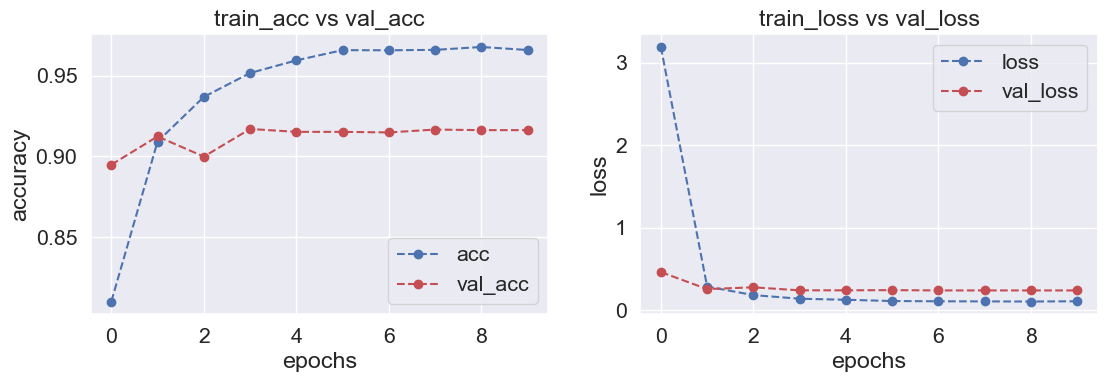

In [61]:
plot_accuracy_loss(history)

In [62]:
from sklearn.metrics import accuracy_score

predictions = model2_Xception.predict(test_features)
pred_labels = np.argmax(predictions, axis=1)
print("Accuracy: {}".format(accuracy_score(test_labels, pred_labels)))

94/94 [==============================] - 3s 36ms/step
Accuracy: 0.912


# Нейросеть VGG 19

In [14]:
from keras.applications import VGG19

In [65]:
model_vgg19 = VGG19(include_top=False, weights='imagenet')

80134624/80134624 [==============================] - 9s 0us/step


In [66]:
train_features = model_vgg19.predict(train_images)
test_features = model_vgg19.predict(test_images)

94/94 [==============================] - 185s 2s/step


In [67]:
_, x, y, z = train_features.shape

In [68]:
lr_rate = ReduceLROnPlateau(monitor='val_accuracy',
                            patience=1,
                            factor=0.25,
                            min_lr=0.000003)

In [74]:
model2_vgg19 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(x, y, z)),
    tf.keras.layers.Dense(100, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model2_vgg19.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

history = model2_vgg19.fit(train_features, train_labels, batch_size=256,
                                 epochs=10, validation_split=0.2, callbacks=[lr_rate])

Epoch 1/10
44/44 [==============================] - 2s 31ms/step - loss: 0.7748 - accuracy: 0.7257 - val_loss: 0.4385 - val_accuracy: 0.8383 - lr: 0.0010
Epoch 2/10
44/44 [==============================] - 1s 27ms/step - loss: 0.3733 - accuracy: 0.8686 - val_loss: 0.3909 - val_accuracy: 0.8575 - lr: 0.0010
Epoch 3/10
44/44 [==============================] - 1s 27ms/step - loss: 0.3119 - accuracy: 0.8891 - val_loss: 0.3824 - val_accuracy: 0.8618 - lr: 0.0010
Epoch 4/10
44/44 [==============================] - 1s 26ms/step - loss: 0.2735 - accuracy: 0.9041 - val_loss: 0.3522 - val_accuracy: 0.8703 - lr: 0.0010
Epoch 5/10
44/44 [==============================] - 1s 27ms/step - loss: 0.2360 - accuracy: 0.9217 - val_loss: 0.3480 - val_accuracy: 0.8682 - lr: 0.0010
Epoch 6/10
44/44 [==============================] - 1s 25ms/step - loss: 0.2064 - accuracy: 0.9336 - val_loss: 0.3370 - val_accuracy: 0.8685 - lr: 2.5000e-04
Epoch 7/10
44/44 [==============================] - 1s 25ms/step - loss:

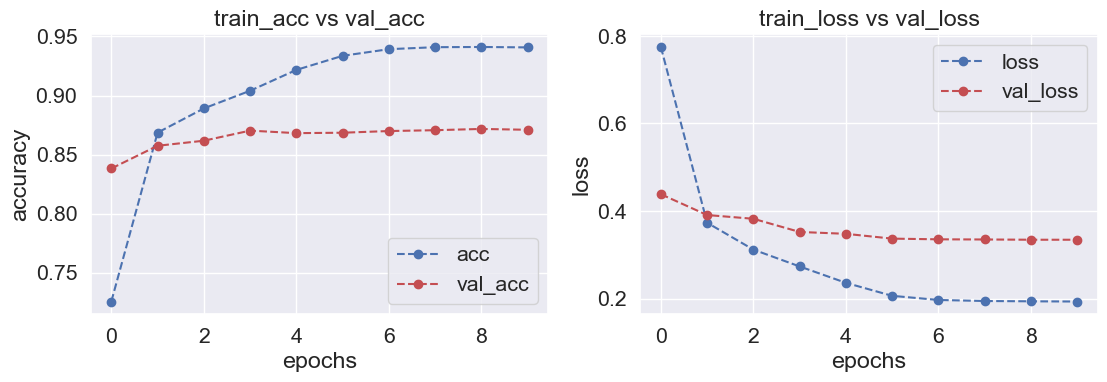

In [75]:
plot_accuracy_loss(history)

In [77]:
from sklearn.metrics import accuracy_score

predictions = model2_vgg19.predict(test_features)
pred_labels = np.argmax(predictions, axis=1)
print("Accuracy: {}".format(accuracy_score(test_labels, pred_labels)))

94/94 [==============================] - 0s 2ms/step
Accuracy: 0.8723333333333333


# Второй вариант нейросети VGG 19

In [17]:
model_vgg19 = VGG19(weights='imagenet', include_top=False)
model_vgg19 = Model(inputs=model_vgg19.inputs, outputs=model_vgg19.layers[-5].output)

In [18]:
train_features = model_vgg19.predict(train_images)
test_features = model_vgg19.predict(test_images)

94/94 [==============================] - 173s 2s/step


In [29]:
model2_vgg19 = VGG19(weights='imagenet', include_top=False)

input_shape = model2_vgg19.layers[-4].get_input_shape_at(0)
layer_input = Input(shape=(9, 9, 512))

x = layer_input
for layer in model2_vgg19.layers[-4::1]:
    x = layer(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dense(6, activation='softmax')(x)

new_model = Model(layer_input, x)

In [30]:
new_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [31]:
new_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 9, 9, 512)]       0         
                                                                 
 block5_conv2 (Conv2D)       multiple                  2359808   
                                                                 
 block5_conv3 (Conv2D)       multiple                  2359808   
                                                                 
 block5_conv4 (Conv2D)       multiple                  2359808   
                                                                 
 block5_pool (MaxPooling2D)  multiple                  0         
                                                                 
 conv2d_4 (Conv2D)           (None, 2, 2, 64)          294976    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 1, 1, 64)         0   

In [32]:
lr_rate = ReduceLROnPlateau(monitor='val_accuracy',
                            patience=1,
                            factor=0.25,
                            min_lr=0.000003)

In [33]:
history = new_model.fit(train_features, train_labels, batch_size=128, epochs=10, validation_split=0.2,
                        callbacks=[lr_rate])

Epoch 1/10
88/88 [==============================] - 225s 3s/step - loss: 0.7477 - accuracy: 0.7165 - val_loss: 0.3876 - val_accuracy: 0.8689 - lr: 0.0010
Epoch 2/10
88/88 [==============================] - 220s 3s/step - loss: 0.4186 - accuracy: 0.8602 - val_loss: 0.3408 - val_accuracy: 0.8831 - lr: 0.0010
Epoch 3/10
88/88 [==============================] - 220s 3s/step - loss: 0.3592 - accuracy: 0.8846 - val_loss: 0.3523 - val_accuracy: 0.8885 - lr: 0.0010
Epoch 4/10
88/88 [==============================] - 221s 3s/step - loss: 0.2955 - accuracy: 0.9026 - val_loss: 0.3189 - val_accuracy: 0.8945 - lr: 0.0010
Epoch 5/10
88/88 [==============================] - 220s 3s/step - loss: 0.2734 - accuracy: 0.9116 - val_loss: 0.3603 - val_accuracy: 0.8931 - lr: 0.0010
Epoch 6/10
88/88 [==============================] - 220s 3s/step - loss: 0.1777 - accuracy: 0.9428 - val_loss: 0.2750 - val_accuracy: 0.9138 - lr: 2.5000e-04
Epoch 7/10
88/88 [==============================] - 220s 3s/step - loss:

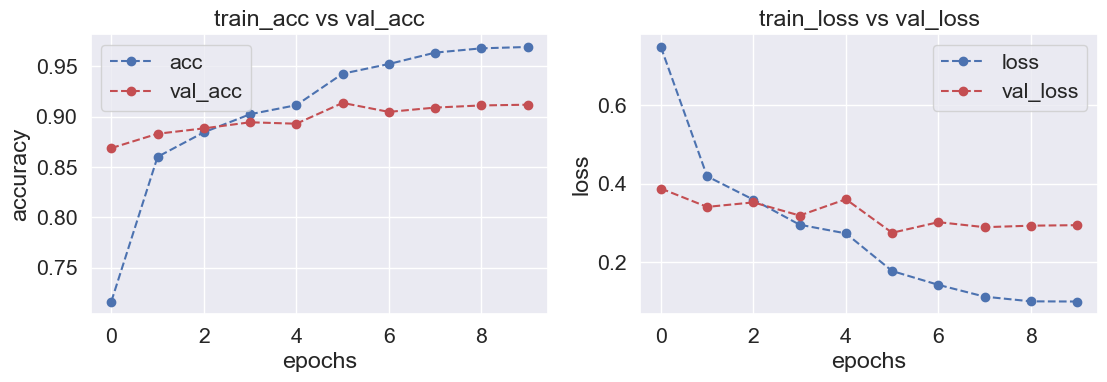

In [34]:
plot_accuracy_loss(history)

In [35]:
from sklearn.metrics import accuracy_score

predictions = new_model.predict(test_features)
pred_labels = np.argmax(predictions, axis=1)
print("Accuracy: {}".format(accuracy_score(test_labels, pred_labels)))

94/94 [==============================] - 13s 141ms/step
Accuracy: 0.905


# Нейросеть ResNet50

In [36]:
from keras.applications import ResNet50V2

Создаем модель ResNet50V2

In [37]:
model_resNet50 = ResNet50V2(include_top=False, weights='imagenet')

94668760/94668760 [==============================] - 11s 0us/step


Извлекаем признаки

In [38]:
train_features = model_resNet50.predict(train_images)
test_features = model_resNet50.predict(test_images)

94/94 [==============================] - 87s 855ms/step


In [39]:
_, x, y, z = train_features.shape

In [40]:
lr_rate = ReduceLROnPlateau(monitor='val_accuracy',
                            patience=1,
                            factor=0.25,
                            min_lr=0.000003)

Обучаем модель

In [57]:
model2_resNet50V2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(x, y, z)),
    tf.keras.layers.Dense(100, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model2_resNet50V2.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

history = model2_resNet50V2.fit(train_features, train_labels, batch_size=256,
                                 epochs=10, validation_split=0.2, callbacks=[lr_rate])

Epoch 1/10
44/44 [==============================] - 7s 144ms/step - loss: 1.0961 - accuracy: 0.8315 - val_loss: 0.3196 - val_accuracy: 0.8953 - lr: 0.0010
Epoch 2/10
44/44 [==============================] - 6s 145ms/step - loss: 0.1664 - accuracy: 0.9434 - val_loss: 0.3130 - val_accuracy: 0.9013 - lr: 0.0010
Epoch 3/10
44/44 [==============================] - 6s 139ms/step - loss: 0.0763 - accuracy: 0.9771 - val_loss: 0.3099 - val_accuracy: 0.9081 - lr: 0.0010
Epoch 4/10
44/44 [==============================] - 6s 133ms/step - loss: 0.0381 - accuracy: 0.9914 - val_loss: 0.3157 - val_accuracy: 0.9059 - lr: 0.0010
Epoch 5/10
44/44 [==============================] - 6s 135ms/step - loss: 0.0190 - accuracy: 0.9971 - val_loss: 0.3118 - val_accuracy: 0.9120 - lr: 2.5000e-04
Epoch 6/10
44/44 [==============================] - 6s 134ms/step - loss: 0.0156 - accuracy: 0.9980 - val_loss: 0.3164 - val_accuracy: 0.9120 - lr: 2.5000e-04
Epoch 7/10
44/44 [==============================] - 6s 135ms/s

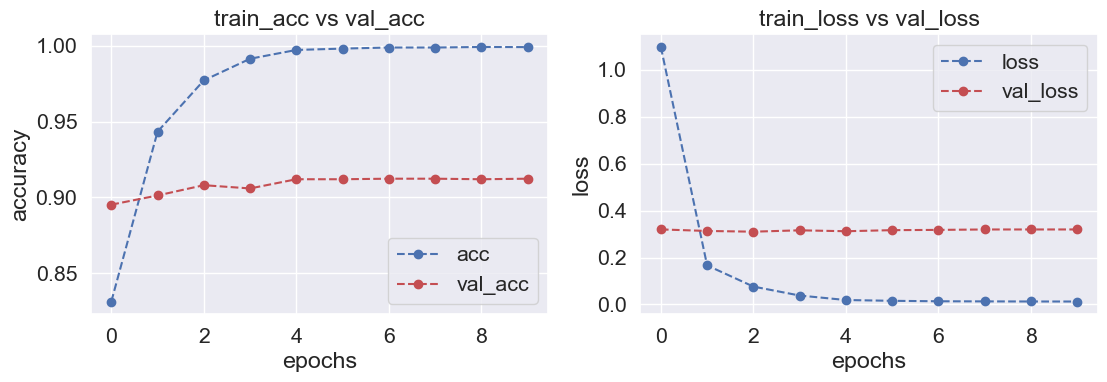

In [58]:
plot_accuracy_loss(history)

Итоговое значение Accuracy

In [59]:
from sklearn.metrics import accuracy_score

predictions = model2_resNet50V2.predict(test_features)
pred_labels = np.argmax(predictions, axis=1)
print("Accuracy: {}".format(accuracy_score(test_labels, pred_labels)))

94/94 [==============================] - 1s 10ms/step
Accuracy: 0.9106666666666666


# Нейросеть ResNet101

In [60]:
from keras.applications import ResNet101V2

Строим модель ResNet101

In [61]:
model_resNet101 = ResNet101V2(include_top=False, weights='imagenet')

171317808/171317808 [==============================] - 20s 0us/step


Извлекаем признаки

In [62]:
train_features = model_resNet101.predict(train_images)
test_features = model_resNet101.predict(test_images)

94/94 [==============================] - 163s 2s/step


In [63]:
_, x, y, z = train_features.shape

In [64]:
lr_rate = ReduceLROnPlateau(monitor='val_accuracy',
                            patience=1,
                            factor=0.25,
                            min_lr=0.000003)

Обучаем нейросеть

In [77]:
model2_resNet101 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(x, y, z)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1024, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model2_resNet101.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

history = model2_resNet101.fit(train_features, train_labels, batch_size=256,
                                 epochs=10, validation_split=0.2, callbacks=[lr_rate])

Epoch 1/10
44/44 [==============================] - 50s 1s/step - loss: 3.5951 - accuracy: 0.8225 - val_loss: 0.5659 - val_accuracy: 0.8903 - lr: 0.0010
Epoch 2/10
44/44 [==============================] - 50s 1s/step - loss: 0.2565 - accuracy: 0.9262 - val_loss: 0.3086 - val_accuracy: 0.9092 - lr: 0.0010
Epoch 3/10
44/44 [==============================] - 49s 1s/step - loss: 0.1208 - accuracy: 0.9572 - val_loss: 0.2945 - val_accuracy: 0.9156 - lr: 0.0010
Epoch 4/10
44/44 [==============================] - 49s 1s/step - loss: 0.0704 - accuracy: 0.9743 - val_loss: 0.3437 - val_accuracy: 0.9056 - lr: 0.0010
Epoch 5/10
44/44 [==============================] - 49s 1s/step - loss: 0.0450 - accuracy: 0.9847 - val_loss: 0.3078 - val_accuracy: 0.9195 - lr: 2.5000e-04
Epoch 6/10
44/44 [==============================] - 50s 1s/step - loss: 0.0344 - accuracy: 0.9887 - val_loss: 0.3049 - val_accuracy: 0.9184 - lr: 2.5000e-04
Epoch 7/10
44/44 [==============================] - 48s 1s/step - loss: 0.

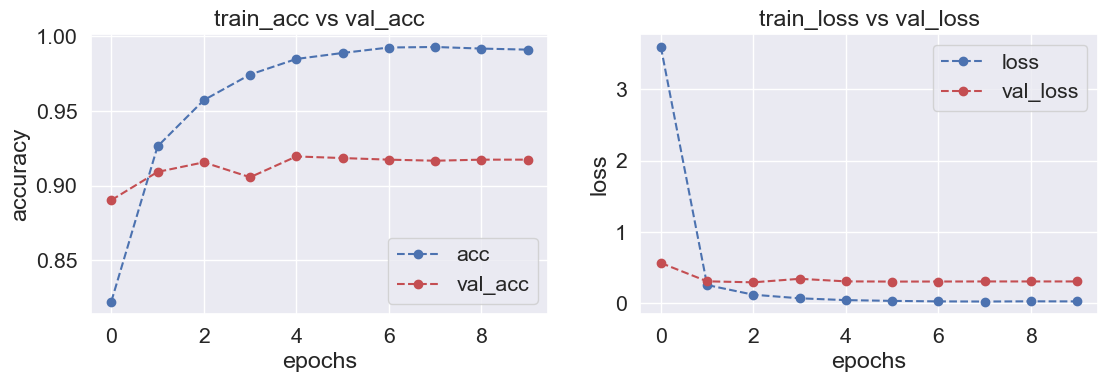

In [78]:
plot_accuracy_loss(history)

Итоговое значение Accuracy

In [79]:
from sklearn.metrics import accuracy_score

predictions = model2_resNet101.predict(test_features)
pred_labels = np.argmax(predictions, axis=1)
print("Accuracy: {}".format(accuracy_score(test_labels, pred_labels)))

94/94 [==============================] - 3s 36ms/step
Accuracy: 0.915


# Нейросеть ResNet152

In [83]:
from keras.applications import ResNet152V2

Создаем модель ResNet152

In [84]:
model_resNet152 = ResNet152V2(include_top=False, weights='imagenet')

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of ed17cf2e0169df9d443503ef94b23b33 so we will re-download the data.
234545216/234545216 [==============================] - 27s 0us/step


Извлекаем признаки

In [85]:
train_features = model_resNet152.predict(train_images)
test_features = model_resNet152.predict(test_images)

94/94 [==============================] - 228s 2s/step


In [ ]:
_, x, y, z = train_features.shape

In [ ]:
lr_rate = ReduceLROnPlateau(monitor='val_accuracy',
                            patience=1,
                            factor=0.25,
                            min_lr=0.000003)

Обучаем модель

In [ ]:
model2_resNet152 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(x, y, z)),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model2_resNet152.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

history = model2_resNet152.fit(train_features, train_labels, batch_size=256,
                                 epochs=10, validation_split=0.2, callbacks=[lr_rate])

In [ ]:
plot_accuracy_loss(history)

Итоговое значение Accuracy

In [ ]:
from sklearn.metrics import accuracy_score

predictions = model2_resNet101.predict(test_features)
pred_labels = np.argmax(predictions, axis=1)
print("Accuracy: {}".format(accuracy_score(test_labels, pred_labels)))